## 11.2 Convolutions

The convolution operation is the main engine of convolutional neural networks (CNNs) and is therefore worth investigating. This exercise will show you how it works and what effect different kernels have on images. You will see how they affect the size of neural networks and you get to play around with an implementation in a browser!

Let's first get a feeling what a single convolution layer does. The following task assumes "same" convolutions, i.e. padding as necessary to keep the output dimensions the same as the input dimensions.

**Task a) Calculate the missing convolution activations with stride 1, apply the ReLU nonlinearity and perform 2x2 max-pooling with stride 2.**

**Solution:**
Don't forget to flip the kernel first! This means mirroring it around the center point. In this example the flipped kernel is $\left[\begin{smallmatrix}1 & 0.25 & 0.5 \\ 1 & 0.5 & -0.25 \\ 2 & 0.5 & 1 \end{smallmatrix} \right]$.

Calculate the entry in the third row and first column: We need to apply zero-padding of 1 to the left border, so the considered part of the input is $\left[\begin{smallmatrix}0 & 4 & -4 \\ 0 & 8 & -1 \\ 0 & -4 & -12 \end{smallmatrix} \right]$. 
Using the flipped kernel, this yields $$a_{20} = 0 \cdot 1 + 4 \cdot 0.25 - 4 \cdot 0.5 + 0 \cdot 1 + 8 \cdot 0.5 - 1 \cdot - 0.25 + 0 \cdot 2 - 4 \cdot 0.5 - 12 \cdot 1 =10.75$$
The same procedure for the bottom right entry yields: $$a_{33} = 4 \cdot 1 - 2 \cdot 0.25 + 0 \cdot 0.5 + 4 \cdot 1 + 8 \cdot 0.5 + 0 \cdot - 0.25 + 0 \cdot 2 + 0 \cdot 0.5 + 0 \cdot 1 = 11.5$$

$$ \text{Image:} \ \begin{array}{|c|c|c|c|}
    \hline
    1 & 8 & -16 & 2 \\
    \hline
    4 & -4 & 1 & 12 \\
    \hline
    8 & -1 & 4 & -2 \\
    \hline
    -4 & -12 & 4 & 8 \\
    \hline
\end{array}
\quad \text{Kernel:} \ 
\begin{array}{|c|c|}
    \hline
    1 & 0.5 & 2\\
    \hline
    -0.25 & 0.5 & 1 \\
    \hline
    0.5 & 0.25 & 1 \\
    \hline
\end{array}
\quad \text{Result:} \ 
\begin{array}{|c|c|c|c|}
    \hline
    -3.5 & 16 & 4 & -7 \\
    \hline
    10.25 & 16.25 & -3.5 & -1.5 \\
    \hline
    \mathbf{-10.75} & 0 & -10.25 & 19 \\
    \hline
    2.5 & -1.25 & -13 & \mathbf{11.5} \\
    \hline
\end{array}
 $$
 
$$
\text{After ReLU:} \ 
\begin{array}{|c|c|c|c|}
    \hline
    0 & 16 & 4 & 0 \\
    \hline
    10.25 & 16.25 & 0 & 0 \\
    \hline
    0 & 0 & 0 & 19 \\
    \hline
    2.5 & 0 & 0 & 11.5 \\
    \hline
\end{array}
\quad \text{After Max Pooling:} \ 
 \begin{array}{|c|c|}
    \hline
     16.25 & 4 \\
    \hline
    2.5 & 19 \\
    \hline
    \hline
\end{array}
$$

_Note_: Make sure you know the [difference between convolution and correlation](http://www.imagemagick.org/Usage/convolve/#convolve_vs_correlate). In many machine learning sources these two are treated as the same, because it makes no difference when we learn the kernels. But for solving tasks like this, the result will differ!



**Task b) Implement the valid convolution operation**

Implement _valid_ convolutions using loops in the function below. To provide you with a reference of what the result should look like, an implementation using the scipy.signal convolution is provided. 

**Solution: **

If you compare the time between the loop solution and scipy you will find a big discrepancy. If you are interested in how this is implemented in practice, you can take a look at the `im2col` method. By appropriately indexing the input and the kernel, we can reduce the whole computation to one large dot product!

Kernel 0 shape: 5x5x3
	Result 0 shape: 28x28
	Result 3 shape: 24x24
	Average computation time: 0.04188s
Kernel 1 shape: 5x7x3
	Result 0 shape: 28x26
	Result 3 shape: 24x22
	Average computation time: 0.05285s
Kernel 2 shape: 8x8x3
	Result 0 shape: 25x25
	Result 3 shape: 21x21
	Average computation time: 0.08510s


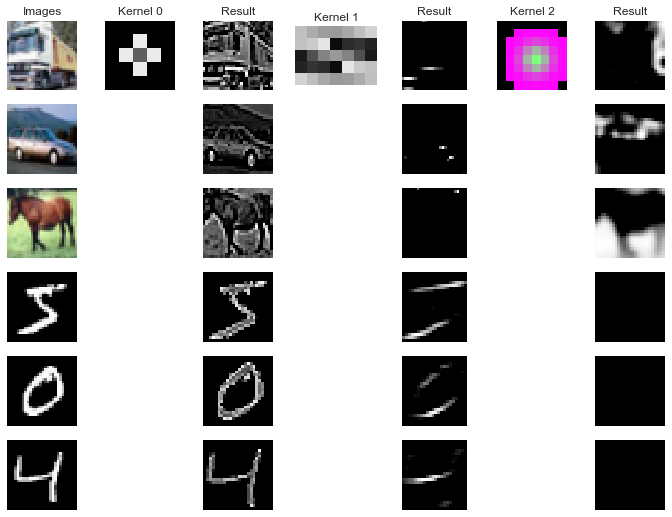

In [4]:
%matplotlib inline
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.signal import convolve as sp_convolve

# Load the prepared data
images = pickle.load(open('images.pkl', 'rb'))
kernels = pickle.load(open('kernels.pkl', 'rb'))
n_images = len(images)
n_kernels = len(kernels)


def convolve(image, kernel, conv_method='scipy'):
    """
    This function convolves an image with a kernel. 
    conv_method decides which way this will be computed.
    'scipy' will use the scipy.signal convolution, whereas 'loop' will
    use your implementation.
    """
    if conv_method == 'scipy':    
        return sp_convolve(image, kernel, mode='valid').squeeze()
    
    # Get the necessary shape information from image and kernel
    kernel_height, kernel_width, kernel_depth = kernel.shape
    image_height, image_width, image_depth = image.shape
    
    # General shape formula (width − kernel_width + 2 * padding) / stride + 1
    # Same for height. For valid convolutions: padding = 0, stride = 1
    out_height = image_height - kernel_height + 1
    out_width = image_width - kernel_width + 1
    
     # TODO: implement the convolution operation with loops
    if conv_method == 'loop':
        out = np.zeros((out_height, out_width))
        
        # Flip the kernel to make the loop simpler
        flipped = kernel[::-1, ::-1, ::-1]
        
        # Loop over the depth. We add the values to 'out'
        for d in range(image_depth):
        
            # Loop over the output image
            for o_y in range(out_height):
                for o_x in range(out_width):
    
                    # Loop over the kernel
                    for k_y in range(kernel_height):
                        for k_x in range(kernel_width):
                            # Because we flipped the kernel already, we don't have
                            # to think about flipping the looping indices here
                            out[o_y, o_x] += image[o_y + k_y, o_x + k_x, d] * flipped[k_y, k_x, d]
    
        return out
    
    if conv_method == 'im2col':
        # Create a 3-dim array with the start coordinates of the receptive fields
        start_idx = np.arange(kernel_height)[:, None, None]*(image_width*image_depth) + \
                             np.arange(kernel_width)[:, None]*image_depth + \
                             np.arange(kernel_depth)
    
        # Create the offset array for the target coordinates in the output image
        offset_idx = np.arange(out_height)[:, None, None]*(image_width*image_depth) + \
                              np.arange(out_width)[:, None] * image_depth
        
        # Flatten the image to a column by using the previous indices.
        image_col = np.take(image, start_idx.ravel()[:, None] + offset_idx.ravel())
        
        # Flatten the kernel as well, but flip it beforehand
        kernel_row = kernel[::-1, ::-1, ::-1].reshape(-1)
        
        # Now the convolution is a simple dot product!
        out = np.dot(kernel_row, image_col)
    
        # But we need to reshape it back to 2 dimensions
        return out.reshape((out_height, out_width))
    
    raise NotImplementedError('Unkown convolution method')
# --- end of the convolution function

# Decide which method to use for convolutions
# TODO: 'loop' should select your method
convolution_method = 'loop'
    
# Evaluation and plotting code. You can ignore the rest of this code cell
fig, axes = plt.subplots(n_images, n_kernels * 2 + 1, figsize=(n_images * 2, n_kernels * 3))
axes[0][0].set_title('Images')
results = [[None]*n_images]*n_kernels

for i in range(n_images):
        axes[i][0].imshow(images[i], interpolation='nearest')
        
        for j in range(n_kernels * 2 + 1):
            axes[i][j].grid(False)
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

for kern in range(n_kernels):
    ks = kernels[kern].shape
    print('Kernel {:d} shape: {:d}x{:d}x{:d}'.format(kern, ks[0], ks[1], ks[2]))
    
    col = kern * 2 + 1
    axes[0][col].set_title('Kernel ' + str(kern))
    axes[0][col].imshow(kernels[kern], interpolation='nearest')
    axes[0][col + 1].set_title('Result')
    
    t_start = time.time()
    
    for i in range(n_images):
        results[kern][i] = convolve(images[i], kernels[kern], conv_method=convolution_method)
        
    duration = time.time() - t_start
        
    for i in range(n_images):
        normalized = np.maximum(results[kern][i], 0.)
        axes[i][col + 1].imshow(normalized, interpolation='nearest', cmap='Greys_r')
        if i > 0:
            axes[i][col].set_visible(False)

    i0s = results[kern][0].shape
    i3s = results[kern][3].shape
    print('\tResult 0 shape: {:d}x{:d}'.format(i0s[0], i0s[1]))
    print('\tResult 3 shape: {:d}x{:d}'.format(i3s[0], i3s[1]))
    print('\tAverage computation time: {:.5f}s'.format(duration / n_images))
pass

**Q 11.2.1: What effect do the different kernels have on the images? How useful would they be for the task of image classification?**

**Answer: ** The first kernel simply sharpens the image and is not really useful for classification, because it does not help distinguish between classes. The second kernel activates for slightly diagonal lines, most noticably for the MNIST digits 5 and 4. The third kernel identifies green(ish) colored blobs, e.g. for the background of the horse image. The pink area appears in the kernel depiction due to matplotlibs normalization of images. The latter two kernels are useful for classification, because they actually identify attributes or appearances in images.

------

**Q 11.2.2: How many weights would each kernel have, if they were trained as part of a convolutional neural network?**

**Answer: **

Kernel 0: $\quad5 \cdot 5 \cdot 3 = 75$

Kernel 1: $\quad5 \cdot 7 \cdot 3 = 105$

Kernel 2: $\quad8 \cdot 8 \cdot 3 = 192$

In implementations of convolutional layers, each kernel usually has an additional bias weight, therefore $76, 106$ and $193$ is also a valid answer.

--------

Take a look at the convolutional filters of the first layer in the seminal [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf):
![](weights.jpeg)
**Q 11.2.3: Given your experience in the first task, what do these kernels detect?**

**Answer: **
The majority consists of [Gabor-like](https://en.wikipedia.org/wiki/Gabor_filter) edge detectors and color blobs as we have seen in task a), similar to the human visual system. 

---

**Bonus: Task c) ConvNetJS**

Andrej Karpathy created an [implementation of convolutional networks](http://cs.stanford.edu/people/karpathy/convnetjs/) for your browser in JavaScript, that works surprisingly well. Feel free to play around with it!